# TableNet: Deep Learning model for end-to-end Table detection and Tabular data extraction from Scanned Document Images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ABSTRACT

<p>
With the widespread use of mobile phones and
scanners to photograph and upload documents, the need for
extracting the information trapped in unstructured document
images such as retail receipts, insurance claim forms and financial
invoices is becoming more acute. A major hurdle to this objective
is that these images often contain information in the form of
tables and extracting data from tabular sub-images presents a
unique set of challenges. This includes accurate detection of the
tabular region within an image, and subsequently detecting and
extracting information from the rows and columns of the detected
table.
</p>

<p>
A reasearch paper where model is proposed as TableNet: a novel end-toend
deep learning model for both table detection and structure
recognition. The model exploits the interdependence between the
twin tasks of table detection and table structure recognition to
segment out the table and column regions. This is followed by
semantic rule-based row extraction from the identified tabular
sub-regions. 
</p>

## Problem Statement

<p>
From a given scanned document image,we have to locate the table and identify its internal structure.After Table and its structure is idetified,information has to be extracted from the table.
</p>

<h2>1.3 Real world Objectives and constraints  </h2>

Objectives:
1. Predict the loation of a bale and its structure and extract its information
2. Minimize the difference between predicted and actual table detection.
<br>

Constraints:
1. Some form of interpretability.

<h1> 2. Machine Learning Problem </h1>

# About Marmot dataset

<p>
This reserach paper is trained on Marmot table dataset which is annotated by the research team.This is the largest publicly available
dataset for table detection.   
</p>
<p>
This annotated dataset consists of 502 scanned images and their corresponding annotation files.Each Annotatin file is a xml file which gives the coordinates of the table and its columns in the images.It is the groud truth for the table detection.
</p>
<p>
For creating model with this data,we have to get the coordinates of the tables from the xml files and then train on the images
</p>

<h2>2.2 Mapping the real world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<pre>
For a given document image we have to do semantic segmentation by classyfying each pixel as a table or not.It is deep learning smenatic segmentatin problem.
</pre>

<h3> 2.2.2 Performance metric </h3>

<pre>
As this is a classification problem following metrics will help in better prediction.
</pre>
<ul>
<li> F1 Score: This metric tries to create a balance between precision and recall.Here we are interested in more numbers of correct predictions. </li>
<li> Precision</li>
<li> Recall</li>
</ul>

In [ ]:
import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.applications.vgg19 import VGG19
from keras import layers

In [26]:
import xml.etree.ElementTree as et
import os
import numpy as np
from PIL import Image

## EDA & Generation of the Data

In [1]:
data_directory='/content/drive/MyDrive/tablenet_colab/marmot_image2/'

In [2]:
col_mask_directory="/content/drive/MyDrive/tablenet_colab/col_mask/"

In [3]:
tbl_mask_directory="/content/drive/MyDrive/tablenet_colab/tbl_mask/"

In [4]:
jpg_img_directory="/content/drive/MyDrive/tablenet_colab/jpgimg/"

10.1.1.1.2006_3.bmp


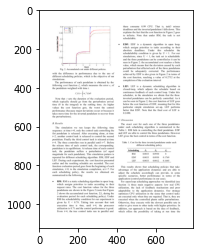

In [ ]:
#Display of scanned images
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline

flst=os.listdir(data_directory)

pil_im = Image.open(data_directory+flst[0])
print(flst[0])
imshow(np.asarray(pil_im))


* All the images are in bmp format and contains at least one table.
* Col mask and table mask have to saved for each image for training purpose.

In [ ]:
import lxml.etree as etree

x = etree.parse(data_directory+flst[1])
print(etree.tostring(x, pretty_print=True,encoding="unicode"))

<annotation verified="yes">
	<folder>MARMOT_ANNOTATION</folder>
	<filename>10.1.1.1.2006_3.bmp</filename>
	<path>/home/monika/Desktop/MARMOT_ANNOTATION/10.1.1.1.2006_3.bmp</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>793</width>
		<height>1123</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>458</xmin>
			<ymin>710</ymin>
			<xmax>517</xmax>
			<ymax>785</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>531</xmin>
			<ymin>710</ymin>
			<xmax>568</xmax>
			<ymax>783</ymax>
		</bndbox>
	</object>
	<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>583</xmin>
			<ymin>712</ymin>
			<xmax>619</xmax>
			<ymax>785</ymax>
		</

* Each xml file contains the coordinates for the columns of the table.
* Each xml fie has to be parsed to get the table and column cordinates and create the corresponding column and table masks from the image.
* Column and table masks are basically images where column & table fields have white pixel and rest of the image is black.
* These masks will serve as ground truth for training on original image.

In [ ]:
def sameTable(ymin_1, ymin_2, ymax_1, ymax_2):
    min_diff = abs(ymin_1 - ymin_2)
    max_diff = abs(ymax_1 - ymax_2)

    if min_diff <= 5 and max_diff <=5:
        return True
    elif min_diff <= 4 and max_diff <=7:
        return True
    elif min_diff <= 7 and max_diff <=4:
        return True
    return False

In [ ]:
for file in os.listdir(data_directory):
    if ".xml" in file:
        filename=file[:-4]
        tree = et.parse(data_directory+file)
        root = tree.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        
        col_mask = np.zeros((height, width), dtype=np.int32)
        table_mask = np.zeros((height, width), dtype = np.int32)
        got_first_column = False
        i=0
        table_xmin = 10000
        table_xmax = 0

        table_ymin = 10000
        table_ymax = 0

        for column in root.findall('object'):
            
            bndbox = column.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            col_mask[ymin:ymax, xmin:xmax] = 255
                                
            if got_first_column:
                if sameTable(prev_ymin, ymin, prev_ymax, ymax) == False:
                    
                    i+=1
                    got_first_column = False
                    table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255
                    
                    table_xmin = 10000
                    table_xmax = 0

                    table_ymin = 10000
                    table_ymax = 0
                        
            if got_first_column == False:
                
                got_first_column = True
                first_xmin = xmin
                    
            prev_ymin = ymin
            prev_ymax = ymax

            table_xmin = min(xmin, table_xmin)
            table_xmax = max(xmax, table_xmax)
                
            table_ymin = min(ymin, table_ymin)
            table_ymax = max(ymax, table_ymax)

        table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255

        im = Image.fromarray(col_mask.astype(np.uint8),'L')
        im.save(col_mask_directory + filename + ".jpeg")

        im = Image.fromarray(table_mask.astype(np.uint8),'L')
        im.save(tbl_mask_directory + filename + ".jpeg")   

In [ ]:
for file in os.listdir(data_directory):
    if ".bmp" in file:
        filename=file[:-4]
        pil_im = Image.open(data_directory+file)
        #im = Image.fromarray(np.asarray(pil_im))
        pil_im.save(jpg_img_directory + filename + ".jpeg")
        

10.1.1.1.2006_3.jpeg


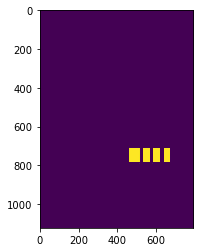

In [ ]:
# Sample Column mask
flst=os.listdir(col_mask_directory)

pil_im = Image.open(col_mask_directory+flst[0])
print(flst[0])
imshow(np.asarray(pil_im))

In [ ]:
flst="/content/drive/MyDrive/tablenet_colab/col_mask/10.1.1.1.2006_3.jpeg"

pil_im = tf.io.read_file(flst)
# print(flst[0])
# imshow(np.asarray(pil_im))
#il_im.mode
#image=pil_im.resize([1024, 1024])
img = tf.image.decode_jpeg(pil_im,channels=3)
img=tf.image.resize(img, [1024, 1024])
img=tf.cast(img, tf.float32) / 255.0

In [ ]:
img.shape

TensorShape([1024, 1024, 3])

10.1.1.1.2006_3.jpeg


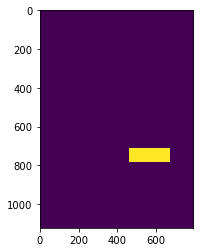

In [ ]:
# Sample Table mask
flst=os.listdir(tbl_mask_directory)

pil_im = Image.open(tbl_mask_directory+flst[0])
print(flst[0])
imshow(np.asarray(pil_im))

# Model

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

In [6]:
img_height, img_width = 1024, 1024

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

def decode_img(img):
    
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
    #image=tf.image.resize(image, [1024, 1024])
    img=tf.image.resize(img, [img_height, img_width])
    #img = np.reshape(img,[1,img_height, img_width,3])
    return img

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
    img=tf.image.resize(img, [img_height, img_width])
    #img = np.reshape(img,[1,img_height, img_width,3])
    return img

def process_path(file_path):
    
    file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')
    img_file_path = tf.strings.regex_replace(file_path, 'marmot_image2', 'jpgimg')
    img_file_path2 = tf.strings.regex_replace(img_file_path, '.bmp', '.jpeg')
    mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')
    table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'marmot_image2', 'tbl_mask')
    column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'marmot_image2', 'col_mask')
    img = normalize(decode_img(tf.io.read_file(img_file_path2)))
    print(img.shape)
    table_mask = decode_mask_img(tf.io.read_file(table_mask_file_path))/255.0
    column_mask = decode_mask_img(tf.io.read_file(column_mask_file_path))/255.0
    return img, {"table_output" : table_mask, "column_output" : column_mask }

In [7]:
xml_dataset = tf.data.Dataset.list_files('/content/drive/MyDrive/tablenet_colab/marmot_image2/*.xml')
#BUFFER_SIZE = 502
#full_dataset = xml_dataset.shuffle(BUFFER_SIZE)

In [8]:
len(list(xml_dataset))

494

In [9]:
train_size = 395
test_size = 99

# full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
# full_dataset = full_dataset.shuffle()
train_dataset = xml_dataset.take(train_size)
test_dataset = xml_dataset.skip(train_size)
#val_dataset = test_dataset.take(val_size)
#test_dataset = test_dataset.skip(val_size)

In [10]:
BATCH_SIZE = 2
TRAIN_LENGTH=len(list(train_dataset))
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
BUFFER_SIZE=494

#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#val_dataset = val_dataset.shuffle(BUFFER_SIZE)


train_dataset = train_dataset.map(process_path)
#val_dataset = val_dataset.map(process_path)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(process_path)

train_dataset1 = train_dataset.batch(BATCH_SIZE).repeat()
train_dataset1 = train_dataset1.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#val_dataset1 = val_dataset.batch(BATCH_SIZE,drop_remainder=True).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset1 = test_dataset.batch(BATCH_SIZE)

(1024, 1024, 3)
(1024, 1024, 3)


In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask','mod image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [13]:
for a,b in train_dataset.take(2):
    print(a.shape)
    #display([a, b['table_output'], b['column_output']])

(256, 256, 3)
(256, 256, 3)


In [12]:
class TableNet:
    @staticmethod
    
    def build_table_decoder(inputs, pool3, pool4):
        #x1=UpSampling2D(size=(2, 2),interpolation='bilinear')(pool4)
        x2=tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid", data_format=None)(pool3)
        x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
        x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x)
        # x = Conv2D(512, (1, 1), activation = 'relu', name='conv8_table')(x)
        # x = Dropout(0.8, name='block8_dropout_column')(x)

        concatenated = Concatenate()([x, pool4])

        x = UpSampling2D(size=(2,2),interpolation='bilinear')(concatenated)
        concatenated = Concatenate()([x, x2])

        x = UpSampling2D(size=(2,2),interpolation='bilinear')(concatenated)
        x = UpSampling2D(size=(2,2),interpolation='bilinear')(x) 
        last = tf.keras.layers.Conv2DTranspose(
      2, 3, strides=2,
        padding='same', name='table_output',activation='softmax')
        #x = last2(x)
        x = last(x)
        return x

    @staticmethod
    def build_column_decoder(inputs, pool3, pool4):
        x2=tf.keras.layers.MaxPooling2D(
          pool_size=(2, 2), strides=None, padding="valid", data_format=None)(pool3)
        x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
        x = Dropout(0.8, name='block7_dropout_column')(x)

        x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
        x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x)

        concatenated = Concatenate()([x, pool4])

        x = UpSampling2D(size=(2,2),interpolation='bilinear')(concatenated)
        concatenated = Concatenate()([x, x2])
        x = UpSampling2D(size=(2,2),interpolation='bilinear')(concatenated)
        x = UpSampling2D(size=(2,2),interpolation='bilinear')(x) 
        last = tf.keras.layers.Conv2DTranspose(
      2, 3, strides=2,
        padding='same', name='column_output',activation='softmax')
        #x = last2(x)
        x = last(x)

        return x  

    @staticmethod
    def vgg_base(inputs):
        base_model = tf.keras.applications.DenseNet121(
        input_shape=[1024, 1024, 3],
        include_top=False, weights='imagenet',classes=1000)
    
        layer_names = ['conv2_block6_concat', 'conv4_block9_0_relu', 'conv5_block1_0_relu']
        layers = [base_model.get_layer(name).output for name in layer_names]

        pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='Densenet')
        pool_layers_model.trainable = False

        return pool_layers_model(inputs)
  
    @staticmethod
    def build():
        inputShape = (1024, 1024, 3)

        inputs = Input(shape=inputShape, name='input')

        pool_layers = TableNet.vgg_base(inputs)

        x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
        x = Dropout(0.8, name='block6_dropout1')(x)
        x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
        x = Dropout(0.8, name = 'block6_dropout2')(x)
    
        table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
        column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1])

        model = Model(			
              inputs=inputs,
			        outputs=[table_mask, column_mask],
			        name="tablenet")
    
        return model

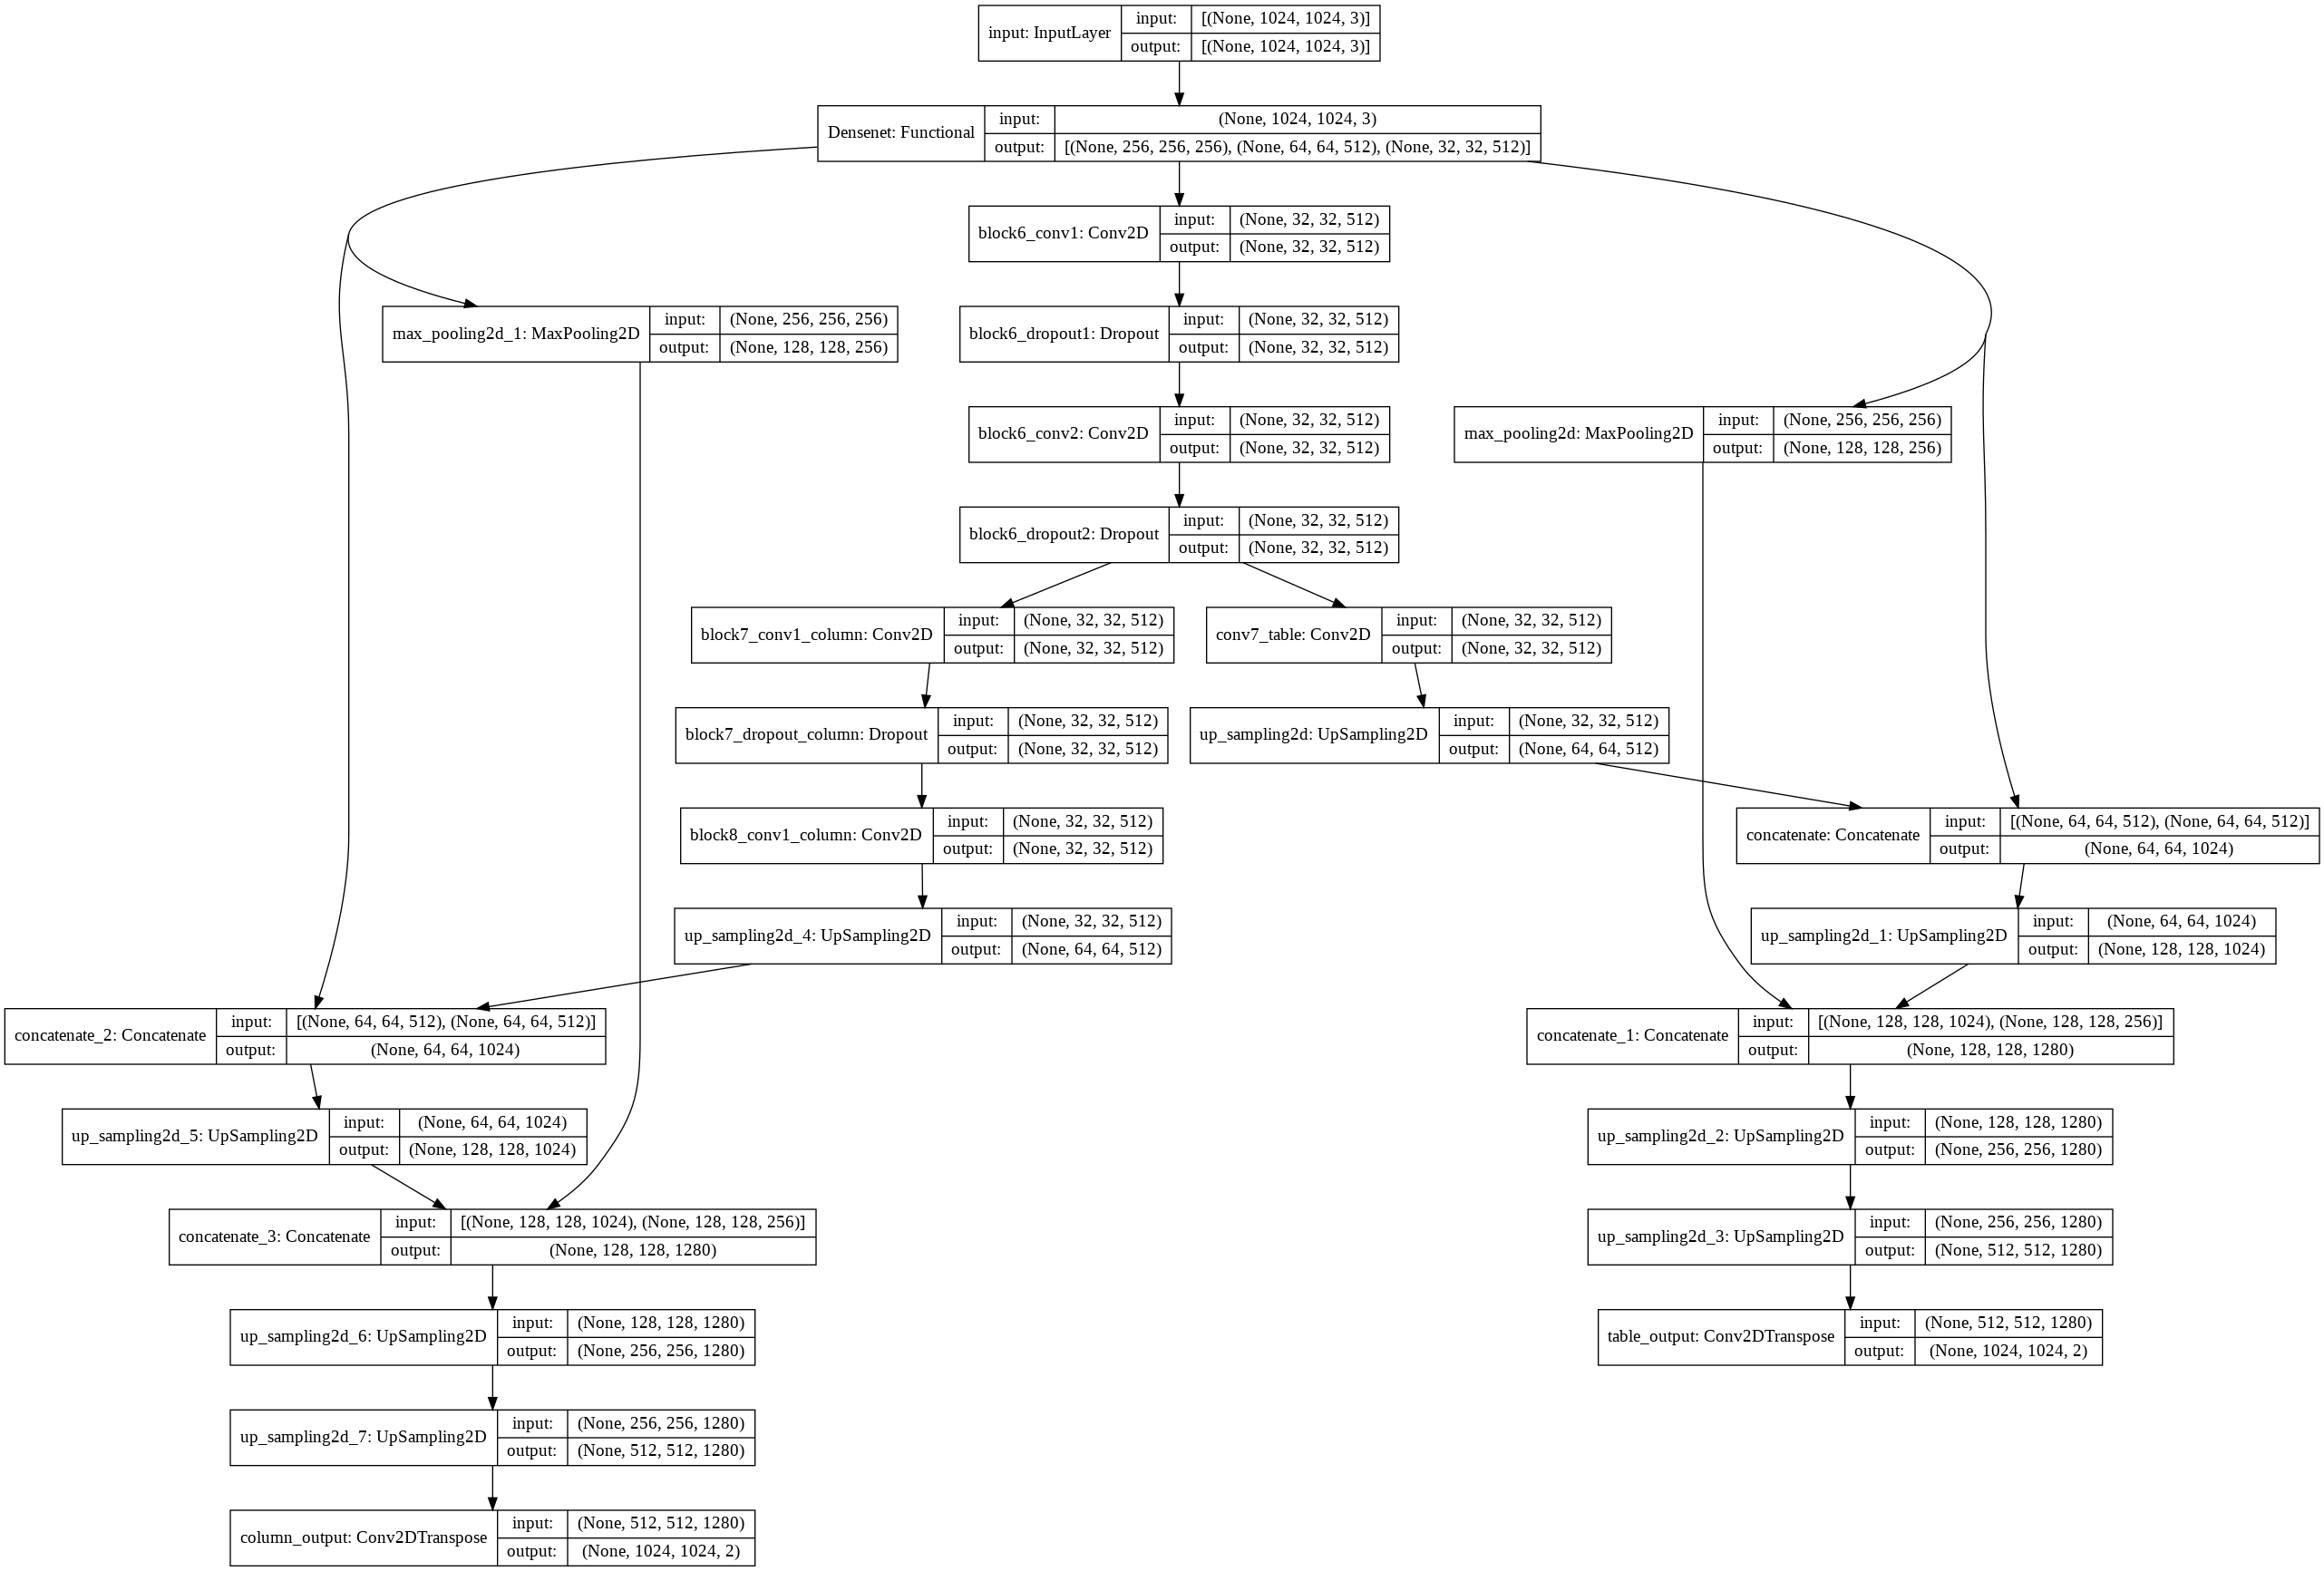

In [13]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)
        #self.f1_list=[]

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred=tf.argmax(y_pred, axis=-1)
        # y_pred=tf.argmax(y_pred, axis=-1)
        p = self.precision_fn(y_true,tf.argmax(y_pred, axis=-1) )
        r = self.recall_fn(y_true, tf.argmax(y_pred, axis=-1))
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))
        #self.f1_list.append(self.f1.assign(2 * ((p * r) / (p + r + 1e-6))))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [15]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]

In [16]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display([sample_image[0], table_mask, column_mask])

In [17]:
for image, mask in train_dataset1.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self):
        self.history = {'table_output_loss':[]}
        self.init_lr = init_lr
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    #show_predictions()
    #print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    if epoch % 1 == 0:
            show_predictions(test_dataset1, 1)
            
            
            self.history['table_output_loss'].append(logs.get('table_output_loss'))
            if epoch > 2:
                cur_loss = self.history['table_output_loss'][epoch]
                prev_loss = self.history['table_output_loss'][epoch-1]

                if cur_loss > prev_loss:
                    self.init_lr = self.init_lr * 0.93
                    K.set_value(self.model.optimizer.learning_rate, self.init_lr)

In [18]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  "column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}



#filepath = "model checkpoint/table_net.h5"
checkpoint1 = ModelCheckpoint("model_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1)
tensorboard1 = TensorBoard(log_dir='Model1_visualization')
metrics1 = F1_Score()
global init_lr
init_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr, epsilon=1e-08),
              loss=losses,
              metrics=[metrics1],
              loss_weights=lossWeights)


1/1 [==============================] - 0s 133ms/step


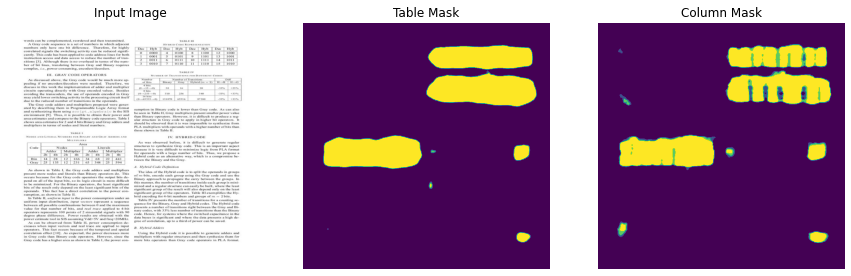

Epoch 00010: early stopping


In [19]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 99//BATCH_SIZE//VAL_SUBSPLITS
train_steps=train_steps = train_size // BATCH_SIZE
history = model.fit(train_dataset1,
                              epochs=EPOCHS,
                              steps_per_epoch=train_steps,
                              validation_data=test_dataset1,
                              validation_steps=VALIDATION_STEPS,
                               callbacks=[checkpoint1,tensorboard1,earlystop1,DisplayCallback()])
#callbacks=[checkpoint1,earlystop1,tensorboard1]

1/1 [==============================] - 0s 56ms/step


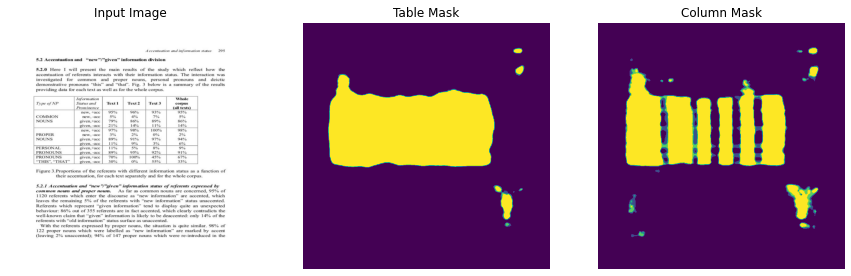

In [20]:
show_predictions()

In [21]:
model.save("/content/drive/MyDrive/tablenet_colab/tablenet.h5")

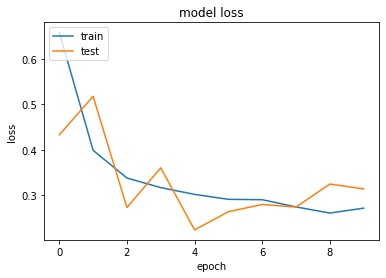

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

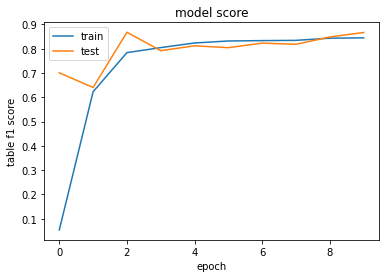

In [23]:

plt.plot(history.history['table_output_f1_score'])
plt.plot(history.history['val_table_output_f1_score'])
plt.title('model score')
plt.ylabel('table f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

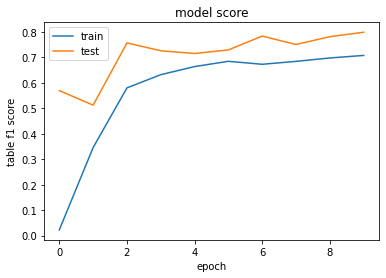

In [24]:

plt.plot(history.history['column_output_f1_score'])
plt.plot(history.history['val_column_output_f1_score'])
plt.title('model score')
plt.ylabel('table f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predictions

In [15]:
model_path = "/content/drive/MyDrive/tablenet_colab/tablenet.h5"
model.load_weights(model_path)

(2, 1024, 1024, 3)


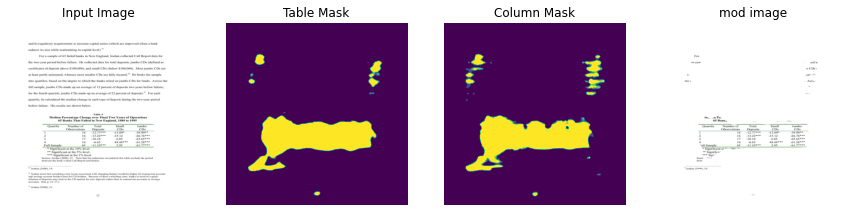

For.

 

 

 

vo-yeat aed a:
10 CDs:
ke p saree
ato c . Acro:
Me. sa Pes
65 Banks a
‘Quartile Number oF Total ‘Small Jumbo
Observations __ Deposits CDs CDs
I 16 -12.77"** __-13.09* =39.90"*
2 16 -13.22%** —-15.12 -66.76"**
3 17 0.18 6.85 -65.65***
4 16 -6.63 44.44°** — -61.28"**
“ull Sample 65 -11.10*** 2.95 -61.77%%*

 

* Significant at © ~ 10% *
** Significay
*** Sige”

Soure ‘=

beww

* Jordan (2000), 19,

(2, 1024, 1024, 3)


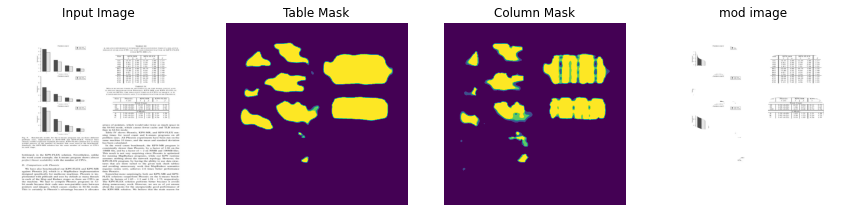

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

Us.

 

 

 

 

: 5
Bi 40
Br, ras
cr Tie
as] ce rar
— ca 1a
cn 122
se Prosar RPE |] KPN re
tte ele ee
soo | 204 «o0s) | 423 | o4s |] 074 276
RSs oO as | aT TSE
B 3920.21) | 3.20 | 123 Hf 2 175
e€ | sasco22 | sis | vos Ia 28

 

(2, 1024, 1024, 3)


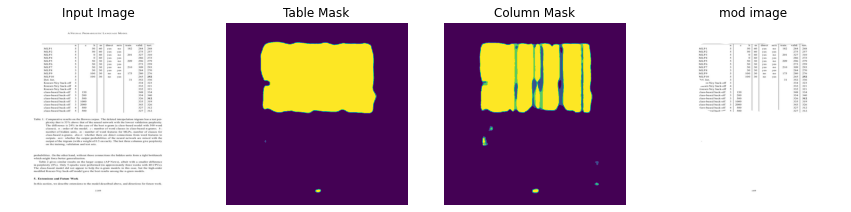

 

MLPI
MLP2
MLP3
MLP4
MLPS
MLP6
MLP7
MLPS
MLP9
MLP10
Yel. Int
er-Ney back-off
-neser-Ney back-off
Kneser-Ney back-off
jass-based back-off
jass-based back-off
class-based back-off
class-based back-off
class-based back-off
slass-based back-off
sed back-«"™

 

VAUEWEUUEYEUUEWOUHHUY

150

38

328

3

50
50

50
50
50
50

100

100

SSssssssgss

149

direct
yes
yes
yes
yes
yes
yes
yes
yes
no
no

no
yes

no
yes
yes
yes
yes

Train,
182

201

209

210

175

31

valid.
284
275
327
286
296
273
309
284
280
265
352
334
332
332
348,
354
326
335
343
327
327

test.
268
257
310
272
279
259
293
270
276
252
336
323
321
321
334
340
312
319
326
312
312

(2, 1024, 1024, 3)


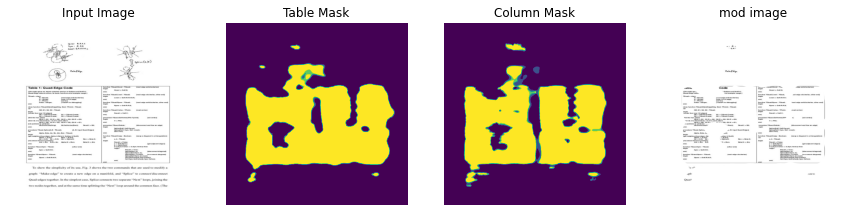

Make Edge

saa

ext edge doctoiee. other and}

nent edge anticloctarien. other ene)

frond vertex)

° (oot vorteny

siiceeaint ana a ae

 

SpeetSar. Sa on)
Spaseisow Sym Sue tment:

 

   

  

 

aerate: erator
~ Lh.
pa Shoes (get agjacent cages)
a
a nett Trees
. (disconnect diagonal)
Seer tomers tee note erin) (ecoment agony
avieeanoan Serene
ra SSS
‘o sh
ph isco:

(2, 1024, 1024, 3)


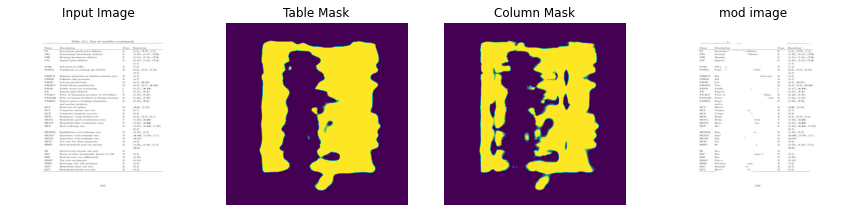

 

  

Name Description Type Equations

Pr Tavestmen= Sn deflator E G6), (7-7), FO)

PIG Govern: Aeflator BE (G16), (5.17), (7-9)

PI Housins E (5.14), (5.15), (7.8)

PM Import | E (4.18), (5.31), (7-2)
(7.7)

POU Op oe x (7.2)

POWA = Pope “ir 6-64) x (6.6), (6.9), (6.10)
(8.3)

PRBUS Bu srest rate |X. (4.8)

PRISK Inf x (4.7)

PROD Lat D (6.3), (6.11)

PRODT Trev D (6.2), (6.4), (6.12)

PSNB Public . I (8.17), (8.18)

Px Export 1 (4.17), (7-4)

PXALU Price of jollars xX (5.22), (5.28)

PXMAR Price ¢ oney X (5.22), (5.28)

PXREG — Expo: E (6.28), (7-3)

and w

RCC Real e D (4.8), (5.10)

RCI Corpor te x 6.7)

RCP Corpor ” x (8.8)

REM Empl x (6.2), (6.3), (64)

REVA Hous: term Qe (4.23), (4.25)

REVD — Hous em Tv (4.24), (4.26)

REX Res BE (4.10), (4.16), (5.26)
(6.2)

REXEQ  Equ te ¥ (4.16), (6.2)

REXM — Imp+ D (4.18), (5.30), (7.1)

REXX Exp " D (4.17)

RFIC Tas x (s.9)

RHPI Re © D (4.23), (4.24), (5.2)
(9.5)

RI Inte x

RIC Rat rome te i 9.3)

RID Rea D (4.16)

RIMP Tax re x (8.1

In [38]:
import pytesseract
from io import StringIO
count = 0
text1=""
for image, mask in test_dataset1.take(5):


    print(image.shape)

    table_mask_pred, col_mask_pred = model.predict(image)

    table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
    table_mask_pred = table_mask_pred[..., tf.newaxis][0]

    col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
    col_mask_pred = col_mask_pred[..., tf.newaxis][0]

    im=tf.keras.preprocessing.image.array_to_img(image[0])
    im.save('image.png')

    im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
    im.save('table_mask_pred.png')

    im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
    im.save('col_mask_pred.png')



    img_org = Image.open('./image.png')
    table_mask = Image.open('./table_mask_pred.png')
    col_mask = Image.open('./col_mask_pred.png')


    # convert images
    img_mask = table_mask.convert('L')
    # img_mask = col_mask.convert('L')

    # grayscale
    # add alpha channel
    img_org.putalpha(img_mask)

    # save as png which keeps alpha channel
    img_org.save('output.png')


    display([image[0], table_mask_pred, col_mask_pred, img_org])

    pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
    text = pytesseract.image_to_string(Image.open('/content/output.png'), lang='eng' ) # config='--psm 11'
    print(text)
    text1=text1+text
with open('csvfile.csv','w') as file:
       
    s = StringIO(text1)     
    for line in s:
        file.write(line)
        file.write('\n')